# Иследование поведения пользователей мобильного приложения
 
На данных стартапа, который продаёт продукты питания, разобраться, как ведут себя пользователи вашего мобильного приложения. 

**Цель исследования**:
1. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
2. Выяснить, какой шрифт лучше: старый или новый.

**Ход исследования**

Данные находятся в файле `/datasets/logs_exp.csv`. О качестве данных ничего не известно. Поэтому понадобится обзор и подготовка данных. 

Ход исследования далее заключается в следующем. Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

Иследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше. Сравнение контрольных групп позволит также понять, сколько времени и данных потребуется для дальнейших тестов.

Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Подготовка данных.
 3. Изучение и проверка данных.
 4. Изучение воронки событий.
 5. Изучение результатов эксперимента.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

* *EventName* — название события;
* *DeviceIDHash* — уникальный идентификатор пользователя;
* *EventTimestamp* — время события;
* *ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### шаг. Изучение общей информации

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy import stats as st
import math as mth

In [119]:
# чтение файла
path = 'C:\\Users\\Kirill\\Documents\\GitHub\\Projects\\'
data = pd.read_csv(path + 'logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### шаг.  Подготовка данных

In [120]:
# меняем названия столбцов
data.columns = ['event_name', 'device_id', 'datetime', 'exp_id']

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   datetime    244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [122]:
# меняем тип данных на нужный
data['datetime'] = pd.to_datetime(data['datetime'], unit='s')
data['device_id'] = data['device_id'].astype(str)
data['exp_id'] = data['exp_id'].astype(str)

# добавляем столбец дат
data['date'] = data['datetime'].dt.date

In [123]:
# Проверим на наличие дубликатов
print(data.duplicated().sum())
# Считаем долю дубликатов
print(data.duplicated().sum()/data.shape[0]*100)

413
0.16917493425526162


Меньше 1 % дубликатов. Удалим их

In [124]:
# Удаляем дубликаты
data = data.drop_duplicates()
# Проверка
data.duplicated().sum()

0

In [125]:
# Проверим пересечения пользователей в группах 
data.groupby('device_id').agg({'exp_id': 'nunique'}).value_counts()

exp_id
1         7551
Name: count, dtype: int64

Пересечений нет.

### шаг.  Изучение и проврка данных

#### Сколько всего событий в логе?

In [126]:
print('Всего {} событий в логе'.format(data['event_name'].count()))

print('Всего {} уникалных событий в логе'.format(len(data['event_name'].value_counts()))) 
data['event_name'].value_counts()

Всего 243713 событий в логе
Всего 5 уникалных событий в логе


event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64

#### Сколько всего пользователей в логе?

In [127]:
'Всего {} пользователь в логе'.format(len(data['device_id'].value_counts())) 

'Всего 7551 пользователь в логе'

#### Сколько в среднем событий приходится на пользователя?

In [128]:
'В среднем {} события приходится на одного пользователя'.format(round(data.groupby('device_id', as_index=False).agg({'event_name': 'count'})['event_name'].mean()))

'В среднем 32 события приходится на одного пользователя'

In [129]:
'Медиана - {} событий'.format(round(data.groupby('device_id', as_index=False).agg({'event_name': 'count'})['event_name'].median()))

'Медиана - 20 событий'

Вывод: имеются аномально большие значения количества событий у некоторых пользователей

#### Данными за какой период мы располагаем? 

In [130]:
# смотрим период 
print('Минимальная и максимальная даты {} и {} соответственно'.format(data['date'].min(), data['date'].max()))

Минимальная и максимальная даты 2019-07-25 и 2019-08-07 соответственно


In [131]:
data['date'].max() - data['date'].min() 

datetime.timedelta(days=13)

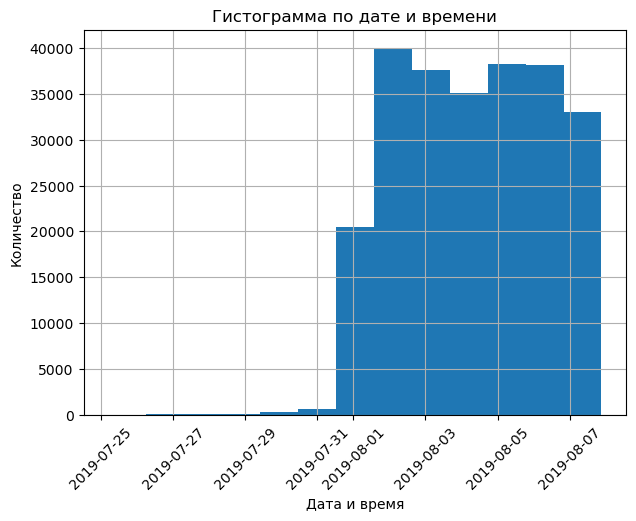

In [132]:
# Создаем объект Figure и добавляем график
fig = plt.figure()
ax = fig.add_subplot(111)

data['datetime'].hist(bins = 13)

# Добавляем названия осей
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество')
plt.xticks(rotation=45) 
# Отображаем гистограмму

# Изменяем размер фигуры
fig.set_size_inches(7, 5)

# Отображаем гистограмму
plt.show()

По графику видим, что основная часть событий была совершена с 1 по 7 августа 2019 года. Посмотрим график именно за этот период.

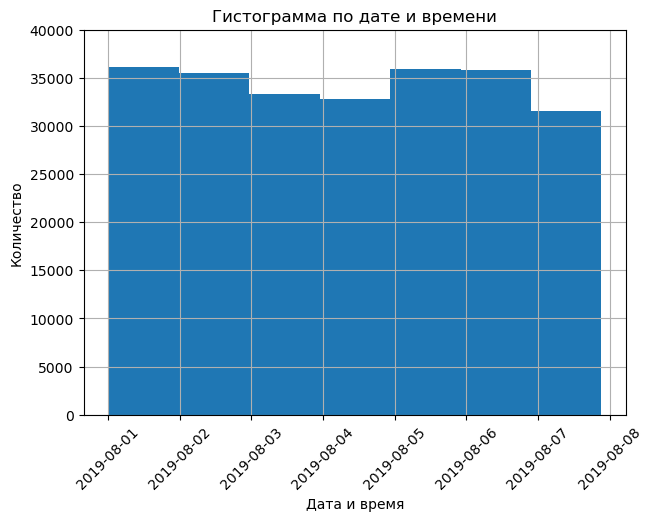

In [133]:
# Создаем объект Figure и добавляем график
fig = plt.figure()
ax = fig.add_subplot(111)

data_new = data[data['datetime']>='2019-08-01']
data_new['datetime'].hist(bins = 7)
plt.ylim (0, 40000)

# Добавляем названия осей
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество')
plt.xticks(rotation=45) 
# Отображаем гистограмму

# Изменяем размер фигуры
fig.set_size_inches(7, 5)

# Отображаем гистограмму
plt.show()

С 1 августа данные полные. Мы отбросили более старые данные и будем дальше работать с датафреймом data_new.

#### Смотрим много ли событий и пользователей мы потеряли, отбросив старые данные.

In [134]:
print('Отбросив старые данные, мы потеряли {} событий'.format(data['event_name'].count() - data_new['event_name'].count()))
print('Это составляет {}% от всех данных'.format(round((data['event_name'].count() - data_new['event_name'].count())/data['event_name'].count()*100, 3)))

Отбросив старые данные, мы потеряли 2826 событий
Это составляет 1.16% от всех данных


In [135]:
print('Отбросив старые данные, мы потеряли {} пользователей'.format(len(data['device_id'].value_counts()) - len(data_new['device_id'].value_counts())))
print('Это составляет {}% от всех данных'.format(round((len(data['device_id'].value_counts()) - len(data_new['device_id'].value_counts()))/len(data['device_id'].value_counts())*100, 3)))

Отбросив старые данные, мы потеряли 17 пользователей
Это составляет 0.225% от всех данных


#### Проверяем,  есть ли у нас  пользователи из всех трёх экспериментальных групп.

In [136]:
print(data['exp_id'].value_counts())
data_new['exp_id'].value_counts()

exp_id
248    85582
246    80181
247    77950
Name: count, dtype: int64


exp_id
248    84563
246    79302
247    77022
Name: count, dtype: int64

Количество пользователей в каждой группе уменьшилось, но у нас есть пользователи из всех трёх экспериментальных групп.

**Выводы 3 шага**:

* Всего в логе 243713 событий, уникалных событий - 5. Всего в логе 7551 пользователь.
* В среднем 32 события приходится на одного пользователя. Но медиана - 20 событий. Это говорит, что в данных имеются аномально большие значения количества событий у некоторых пользователей.
* Располагаем данными за период с 2019-07-25 по 2019-08-07.
* Основная часть событий была совершена с 1 по 7 августа 2019 года, поэтому мы отбросили более старые данные и решили, что будем дальше работать с датафреймом data_new. Отбросив старые данные, мы потеряли 2826 событий. Это составляет 1.16% от всех данных. Отбросив старые данные, мы потеряли 17 пользователей. Это составляет 0.225% от всех данных.
* После количество пользователей в каждой группе уменьшилось, но у нас есть пользователи из всех трёх экспериментальных групп.

### шаг.  Изучаем воронку событий

#### Смотрим, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [137]:
data_new['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

Чаще в логах встречется событие MainScreenAppear, т.е. появление главного экрана, реже всего - руководство использования. 

Переведем на русский:

Появление главного экрана -> Появление экрана предложений -> Появление экрана корзины -> Экран оплаты успешно -> Руководство

#### Считаем, сколько пользователей совершали каждое из этих событий. Считаем долю пользователей, которые хоть раз совершали событие.

In [138]:
event = data_new.groupby('event_name', as_index=False).agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False)
event = event.rename(columns = {'device_id':'device_count'})
event

,event_name,device_count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [139]:
# считаем долю пользователей, которые хоть раз совершали событие
event['share'] = round(event['device_count']/data_new['device_id'].nunique()*100, 2)
event

,event_name,device_count,share
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


#### Предпологаем, в каком порядке происходят события. 

Исходя из полученных данных, Tutorial или Обучение пользователя не являются обязательными для всех пользователей (кто хочет, тот проходит). Уберем Tutorial из воронки

Скорее всего порядок событий следующий:

`Появление главного экрана -> Появление экрана предложений -> Появление экрана корзины -> Экран оплаты успешно`

In [140]:
# Убераем Tutorial из воронки
event = event.query("event_name != 'Tutorial'") 
event

,event_name,device_count,share
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


#### По воронке событий считаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [141]:
# находим долю

event.loc[:, 'share_next_step'] = round(event['device_count'] / event['device_count'].shift(1) * 100, 2)

event = event.sort_values(by='device_count', ascending=False).reset_index(drop=True)
event

C:\Users\Kirill\AppData\Local\Temp\ipykernel_1484\2653577998.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_name,device_count,share,share_next_step
0,MainScreenAppear,7419,98.47,NaN
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


In [142]:
fig = px.funnel(event, y='device_count', x='event_name')
fig.update_layout(title_text='Воронка', title_x=0.5)
fig.show()

Доля пользователей, которая проходит на следующий шаг воронки: 

* MainScreenAppear -> OffersScreenAppear - 61.91%
* OffersScreenAppear -> CartScreenAppear - 81.3%	
* CartScreenAppear ->	PaymentScreenSuccessful	- 94.78%

То есть процент перехода с события на следующее событие в воронке увеличивается.

#### На каком шаге теряете больше всего пользователей?

Больше всего пользователей теряется при переходе с шага `Появление главного экрана` на `Появление экрана предложений`. Возможно дизайн главной страницы не совсем интутивный, и поэтому не все пользователи разобрались куда же дальше нажимать.

#### Какая доля пользователей доходит от первого события до оплаты?

In [143]:
f"От первого события до оплаты доходит {(event['device_count'].iloc[3]/event['device_count'].iloc[0]*100):.1f}% пользователей"

'От первого события до оплаты доходит 47.7% пользователей'

**Выводы 4 шага**:

Чаще в логах встречется событие MainScreenAppear, т.е. появление главного экрана, реже всего - руководство использования.

Было выявлено, что Tutorial или Обучение пользователя не является обязательным шагом для пользователей (кто хочет, тот проходит). Поэтому мы убрали Tutorial из воронки.

Был сформирован порядок событий: Появление главного экрана -> Появление экрана предложений -> Появление экрана корзины -> Экран оплаты успешно 

Также мы расчитали долю пользователей, которая проходит на следующий шаг воронки:

* MainScreenAppear -> OffersScreenAppear - 61.91%
* OffersScreenAppear -> CartScreenAppear - 81.3%
* CartScreenAppear -> PaymentScreenSuccessful - 94.78%

Больше всего пользователей теряется при переходе с шага Появление главного экрана на Появление экрана предложений. Возможно дизайн главной страницы не совсем интутивный, и поэтому не все пользователи разобрались куда же дальше нажимать.

От первого события до оплаты доходит 47.7% пользователей.

### шаг.  Изучение результатов эксперимента

#### Сколько пользователей в каждой экспериментальной группе?

In [144]:
data_groupby = data_new.groupby('exp_id').agg({'device_id': 'nunique'})
data_groupby

,device_id
exp_id,
246,2484
247,2513
248,2537


В группах 246 и 247 (A/A тест) 2484 и 2513 пользователей.

#### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Выберем самое популярное событие.  Проверим, будет ли отличие между группами статистически достоверным.

In [145]:
# строим сводную таблицу
data_pivot = data_new.pivot_table(index='exp_id', columns = 'event_name', values='device_id',aggfunc='nunique')#.reset_index(drop=True)
# удаляем этап воронки Tutorial
data_pivot = data_pivot.drop('Tutorial', axis=1)
# объединим data_groupby и data_pivot
data_merged = pd.merge(data_groupby, data_pivot, on='exp_id')
data_merged = data_merged.rename(columns = {'device_id':'total_devices'})
data_merged

,total_devices,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
exp_id,,,,,
246,2484,1266,2450,1542,1200
247,2513,1238,2476,1520,1158
248,2537,1230,2493,1531,1181


Самое популярное событие - MainScreenAppear.

Теперь надо выбрать уровень значимости. Чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости,  применим метод  Шидака:

Мы будем иметь 16 гипотез, которые мы тестируем одновременно, поэтому при ɑ = 0.05 и при 16 сравнениях требуемый уровень значимости будет расчитываться так: 

In [146]:
alpha_shidak = round(1 - (1 - 0.05)**(1/16), 4)
alpha_shidak

0.0032

In [147]:
def hypothesis_testing (success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Сформулируем гипотезы для четырех тестов.

* H0 - различий между долями нет.
* H1 - между долями есть значимая разница.

Возьмем за уровень статистической значимости расчитанный нами alpha_shidak.

Дальше лучше напишем функцию, которая возвратит результаты проверки гипотез для каждого этапа воронки выбранных групп.

In [148]:
def hypothesis_result(group_one, group_two):
    devices_count = ([data_merged['total_devices'][group_one], data_merged['total_devices'][group_two]])
    MainScreenAppear_count = ([data_merged['MainScreenAppear'][group_one], data_merged['MainScreenAppear'][group_two]])
    OffersScreenAppear_count = ([data_merged['OffersScreenAppear'][group_one], data_merged['OffersScreenAppear'][group_two]])
    CartScreenAppear_count = ([data_merged['CartScreenAppear'][group_one], data_merged['CartScreenAppear'][group_two]])
    PaymentScreenSuccessful_count = ([data_merged['PaymentScreenSuccessful'][group_one], data_merged['PaymentScreenSuccessful'][group_two]])

    print('Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг MainScreenAppear')
    hypothesis_testing(MainScreenAppear_count, devices_count, alpha_shidak)
    print()
    print('Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг OffersScreenAppear')
    hypothesis_testing(OffersScreenAppear_count, devices_count, alpha_shidak)
    print()
    print('Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг CartScreenAppear')
    hypothesis_testing(CartScreenAppear_count, devices_count, alpha_shidak)
    print()
    print('Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг PaymentScreenSuccessful')
    hypothesis_testing(PaymentScreenSuccessful_count, devices_count, alpha_shidak)  

In [149]:
# сравниваем контрольные группы
hypothesis_result(0, 1)

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нет оснований считать доли 246 и 247 групп разными, а значит мы можем проводить A/B-эксперимент.

#### Аналогично почтупаем с группой с изменённым шрифтом. Сравниваем результаты с каждой из контрольных групп в отдельности по каждому событию. Сравниваем результаты с объединённой контрольной группой. 

In [150]:
# суммируем значения контрольных групп
data_merged.loc['249'] = [data_merged['total_devices'][0]+data_merged['total_devices'][1], data_merged['CartScreenAppear'][0]+data_merged['CartScreenAppear'][1], data_merged['MainScreenAppear'][0]+data_merged['MainScreenAppear'][1], data_merged['OffersScreenAppear'][0]+data_merged['OffersScreenAppear'][1], data_merged['PaymentScreenSuccessful'][0]+data_merged['PaymentScreenSuccessful'][1]]
data_merged

,total_devices,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
exp_id,,,,,
246,2484,1266,2450,1542,1200
247,2513,1238,2476,1520,1158
248,2537,1230,2493,1531,1181
249,4997,2504,4926,3062,2358


Сформулируем гипотезы тестов.

* H0 - различий между долями нет.
* H1 - между долями есть значимая разница.

Возьмем за уровень статистической значимости также alpha_shidak.

In [151]:
# сравниваем 246 и 248 группы
hypothesis_result(0, 2)

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между 246 и 248 группами статистически значимых различий нет.

In [152]:
# сравниваем 247 и 248 группы
hypothesis_result(1, 2)

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между 247 и 248 группами статистически значимых различий нет. Это и логично, поскольку раннее мы увидели, что между контрольными группами также не наблюдается статистически значимых различий.

In [153]:
# сравниваем 249 и 248 группы
hypothesis_result(2, 3)

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между 249 и 248 группами статистически значимых различий нет.

#### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез вы сделали.

Всего мы провели 16 тестов, как и предположили перед расчетом альфа с помощью метода Шидака. 
Заметим, что, если бы мы взяли уровень значимости равный 10%, то при сравнении 246 и 248 групп, рез-ты теста по долям общего кол-ва пользователей и кол-ва пользователей, перешедших на шаг CartScreenAppear показали статистическое различие между группами.

### Итоги исследования

Располагаем данными за период с 2019-07-25 по 2019-08-07. Чаще в логах встречется событие MainScreenAppear, т.е. появление главного экрана, реже всего - руководство использования.

Было выявлено, что Tutorial или Обучение пользователя не является обязательным шагом для пользователей (кто хочет, тот проходит). Поэтому мы убрали Tutorial из воронки

Был сформирован порядок событий:
Появление главного экрана -> Появление экрана предложений -> Появление экрана корзины -> Экран оплаты успешно
Также мы расчитали долю пользователей, которая проходит на следующий шаг воронки: 

* MainScreenAppear -> OffersScreenAppear - 61.91%
* OffersScreenAppear -> CartScreenAppear - 81.3%	
* CartScreenAppear ->	PaymentScreenSuccessful	- 94.78%

Больше всего пользователей теряется при переходе с шага "Появление главного экрана" на "Появление экрана предложений". Возможно дизайн главной страницы не совсем интутивный, и поэтому не все пользователи разобрались куда же дальше нажимать, или возникают ошибки при переходе. Рекомендуется более точно проанализировать причины, например, через обратную связь от клиентов или UX-исследования.

На этапе выбора уровеня значимости мы решили использовать метод  Шидака, чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости.
Мы подсчитали, что будем иметь 16 гипотез, которые мы тестируем одновременно, поэтому при ɑ = 0.05 требуемый уровень значимости вышел равным 0.0032.

После A/A теста мы сделали вывод, что нет оснований считать доли контрольных групп 246 и 247 разными. Также было выявлено, что между 246 и 248, 247 и 248 и объединённой контрольной группой и 248 группами статистически значимых различий нет. Результы A/A/B-теста говорят, что, если поменять шрифт на новый, то лучше результаты не станут. 
